In [1]:
import pandas as pd

predictions = pd.read_csv('Data/predictions.xls')
data_inp = pd.read_csv('Data/fbpac-ads-en-US.csv')

In [2]:
data = pd.merge(predictions, data_inp, on='id', how='inner')

In [3]:
# Ensure 'created_at' is datetime and convert to UTC if not already
data['created_at'] = pd.to_datetime(data['created_at'], utc=True, errors='coerce')  # 'coerce' handles any parsing errors gracefully

# Define the date ranges for March for Our Lives and Parkland shooting
march_for_our_lives_date = pd.to_datetime('2018-03-24', utc=True)

# Define 6 months timedelta
six_months = pd.Timedelta(days=6*30)

# Filter messages related to March for Our Lives
before_march = data[(data['created_at'] > (march_for_our_lives_date - six_months)) & (data['created_at'] <= march_for_our_lives_date)]
after_march = data[(data['created_at'] > march_for_our_lives_date) & (data['created_at'] <= (march_for_our_lives_date + six_months))]


In [4]:
# Filter observations where column_name is 1 before and after March for Our Lives
before_march_count = data[(data['label'] == 1) & 
                        (data['created_at'] > (march_for_our_lives_date - six_months)) & 
                        (data['created_at'] <= march_for_our_lives_date)].shape[0]

after_march_count = data[(data['label'] == 1) & 
                       (data['created_at'] > march_for_our_lives_date) & 
                       (data['created_at'] <= (march_for_our_lives_date + six_months))].shape[0]

In [5]:
print(before_march_count)
print(after_march_count)

2706
4995


In [6]:
from bs4 import BeautifulSoup

def clean_html(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup.get_text()


data['message'] = data['message'].apply(clean_html)

/tmp/ipykernel_5250/2852580962.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = gun_ads.groupby(pd.Grouper(key='created_at', freq='M')).size()


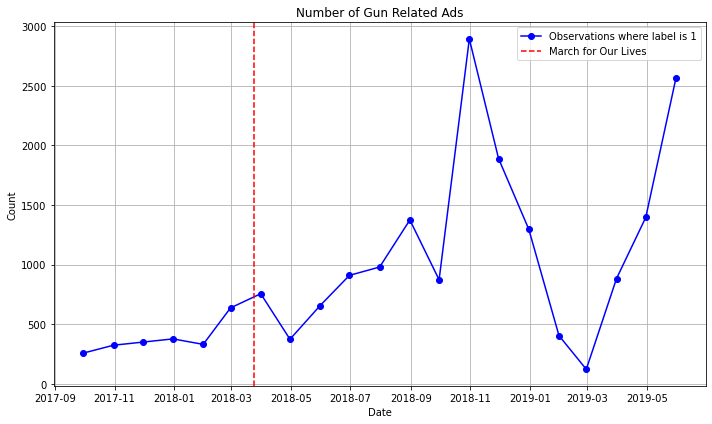

In [7]:
import matplotlib.pyplot as plt

# Filter observations where column_name is 1
gun_ads = data[data['label'] == 1]

# Group by month and count occurrences
monthly_counts = gun_ads.groupby(pd.Grouper(key='created_at', freq='M')).size()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_counts.index.to_numpy(), monthly_counts.to_numpy(), marker='o', linestyle='-', color='b', label='Observations where label is 1')
plt.axvline(march_for_our_lives_date, color='r', linestyle='--', label='March for Our Lives')
plt.title('Number of Gun Related Ads')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')

# Text preprocessing function
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    
    # Stemming
    porter = PorterStemmer()
    tokens = [porter.stem(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply preprocessing to the 'text' column
data['processed_text'] = data['message'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /home/jandolina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jandolina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Compute TF-IDF for each label
tfidf_scores = {}
for label in data['label'].unique():
    # Filter data by label
    texts = data[data['label'] == label]['processed_text'].values
    
    # Fit the vectorizer and transform the processed text
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Get feature names (words)
    feature_names = vectorizer.get_feature_names()
    
    # Calculate TF-IDF scores and store in dictionary
    tfidf_scores[label] = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

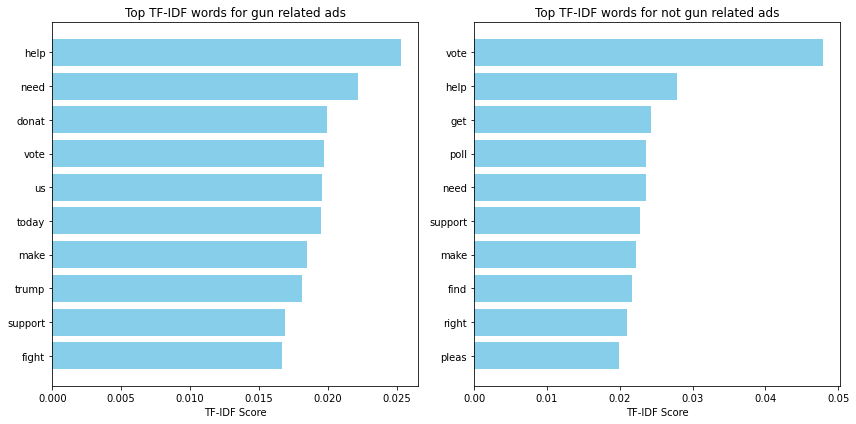

In [10]:
# Plotting TF-IDF scores for each label
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for i, label in enumerate(data['label'].unique()):
    # Determine label title
    if label == 1:
        title = 'Top TF-IDF words for gun related ads'
    else:
        title = 'Top TF-IDF words for not gun related ads'
    
    # Sort TF-IDF scores for the label
    top_tfidf = tfidf_scores[label].mean().sort_values(ascending=False).head(10)
    
    # Plot bar chart
    ax = axes[i]
    ax.barh(top_tfidf.index, top_tfidf.values, color='skyblue')
    ax.set_title(title)
    ax.set_xlabel('TF-IDF Score')
    ax.invert_yaxis()  # Invert y-axis to show highest TF-IDF at the top

plt.tight_layout()
plt.show()


In [28]:
pip install WordCloud


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.6/513.6 kB 32.9 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


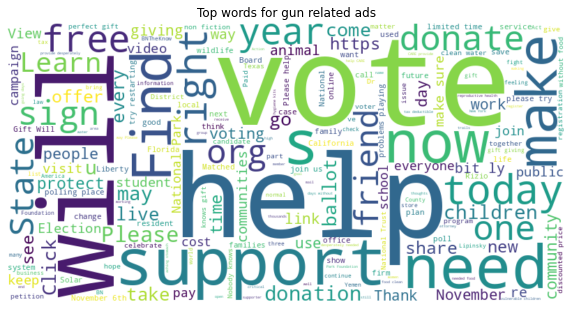

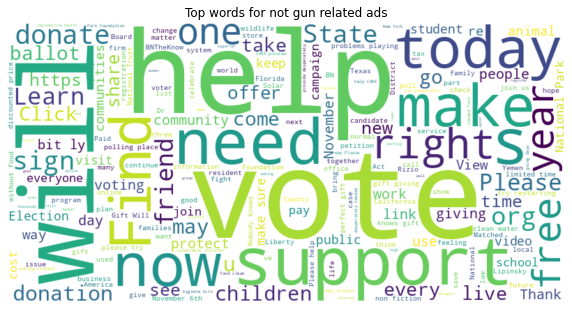

In [30]:
from wordcloud import WordCloud

# Create word clouds for each label
for label in data['label'].unique():
    # Combine all text for this label into a single string
    if label == 1:
        title = 'Top words for gun related ads'
    else:
        title = 'Top words for not gun related ads'
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [31]:
pip install vaderSentiment


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 13.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [41]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

labels = []
avg_sentiments = []

# Initialize Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Iterate over unique labels
unique_labels = data['label'].unique()

for label in unique_labels:
    # Filter data for the current label
    subset_df = data[data['label'] == label]
    
    # Perform sentiment analysis for each text in the subset
    sentiments = []
    for text in subset_df['message']:
        scores = analyzer.polarity_scores(text)
        sentiments.append(scores['compound'])  # Use compound score for overall sentiment
    
    # Calculate average sentiment score for the label
    avg_sentiment = sum(sentiments) / len(sentiments)
    
    # Store label and average sentiment
    labels.append(label)
    avg_sentiments.append(avg_sentiment)

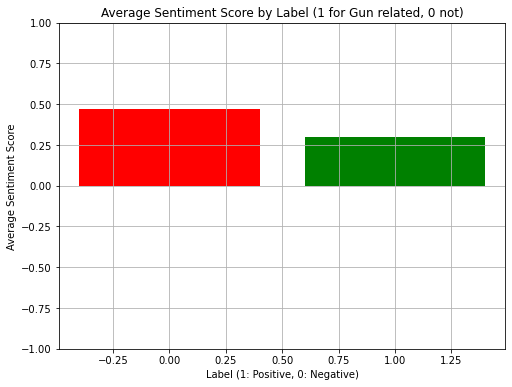

In [45]:
for label in unique_labels:
    # Filter data for the current label
    subset_df = data[data['label'] == label]
    
    # Perform sentiment analysis for each text in the subset
    sentiments = []
    for text in subset_df['message']:
        scores = analyzer.polarity_scores(text)
        sentiments.append(scores['compound'])  # Use compound score for overall sentiment
    
    # Calculate average sentiment score for the label
    avg_sentiment = sum(sentiments) / len(sentiments)
    
    # Store label and average sentiment
    labels.append(label)
    avg_sentiments.append(avg_sentiment)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.bar(labels, avg_sentiments, color=['green', 'red'])
plt.xlabel('Label (1: Positive, 0: Negative)')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score by Label (1 for Gun related, 0 not)')
plt.ylim(-1, 1)  # Setting y-axis limits from -1 to 1 for VADER sentiment scores
plt.grid(True)
plt.show()